In [4]:
#导入相关包
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection  import train_test_split
from sklearn import linear_model
from sklearn.metrics import f1_score
import pre_process

In [14]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [12]:
#读取相关文件
train_path = '../data/train.csv'
test_path = '../data/test.csv'
submit_path = '../data/车辆贷款违约预测挑战赛sample_submit.csv'
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
submit_data = pd.read_csv(submit_path)
#生成提交文件
submit_data['customer_id'] = test_data['customer_id']
submit_data['loan_default'] = 0

In [13]:
train_data,test_data = pre_process.fill_inf(train_data,test_data)#填补inf值
train_data,test_data = pre_process.del_singular_feature(train_data,test_data)#删除单值属性

In [18]:
def find_outliers(model,X,y,sigma=3):
    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X),index=y.index)
    # if predicting fails, try fitting the model first
    except:
        model.fit(X,y)
        y_pred = pd.Series(model.predict(X),index=y.index)
    
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid  = resid.std()
    
    # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid-mean_resid)/std_resid
    outliers = z[abs(z)>sigma].index
    return outliers

# 通过岭回归模型找出异常值，并绘制其分布

X_train = train_data.iloc[:,0:-1]
y_train = train_data.iloc[:,-1]
outliers = find_outliers(Ridge(),X_train,y_train)
outlier_index = list(outliers)
outlier_sum = np.sum(train_data.iloc[outlier_index]['loan_default'].values)
print(outlier_sum/len(outlier_index)*100)
train_data=train_data.drop(labels=outlier_index)

nan


D:\tools\conda\envs\ml\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in longlong_scalars


In [23]:

X_train = test_data.iloc[:,0:-1]
y_train = test_data.iloc[:,-1]
outliers = find_outliers(Ridge(),X_train,y_train)
outlier_index = list(outliers)

outlier_sum = np.sum(train_data.iloc[outlier_index]['loan_default'].values)
print(outlier_sum/len(outlier_index)*100)

test_data=test_data.drop(labels=outlier_index)

nan


D:\tools\conda\envs\ml\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  


In [24]:
#划分数据集
labels = train_data['loan_default'].values
features_scaler = train_data.drop(['loan_default'],axis=1).values
X_train,X_test, y_train, y_test = train_test_split(features_scaler, labels, test_size = 0.2, random_state = 0)

In [25]:
#标准化特征值
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

#标准化特征值(测试数据)
sc = StandardScaler()
sc.fit(test_data)
test_data_std = sc.transform(test_data)

In [26]:
def calculate_f1(model):
    y_pred = model.predict(X_test)
    y_true = y_test
    score = f1_score(y_true, y_pred, average='macro')
    return score

In [30]:
#训练逻辑回归模型
model = linear_model.LogisticRegression(n_jobs=-1)
model = model.fit(X_train, y_train)
print("f1:",calculate_f1(model))

f1: 0.45146190275923864


model: liblinear done
model: lbfgs done
model: sag done


D:\tools\conda\envs\ml\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\tools\conda\envs\ml\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\tools\conda\envs\ml\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\tools\conda\envs\ml\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\tools\conda\envs\ml\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search alg

model: newton-cg done
model: saga done


<AxesSubplot:title={'center':'score change with solver'}, xlabel='solver'>

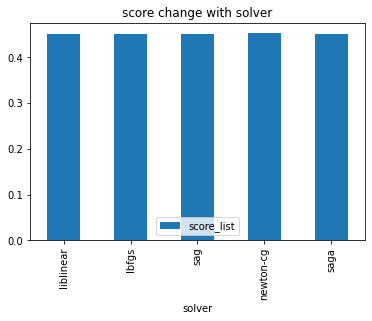

In [32]:
#logistic_regression solver
i_list = ['liblinear','lbfgs','sag','newton-cg','saga']
score_list = []
for i in i_list:
    model = linear_model.LogisticRegression(
        solver=i,
        max_iter=10000
    )
    model = model.fit(X_train, y_train)
    score_list.append(calculate_f1(model))
    print("model:",i,"done")
score_list_df =  pd.DataFrame({'solver':i_list,'score_list':score_list})
score_list_df.plot(x='solver' ,y='score_list',title='score change with solver',kind='bar') 
#newton-cg、sag 和 lbfgs 算法只能使用 l2 正则化

In [33]:
print(score_list)

[0.45146190275923864, 0.45146190275923864, 0.45146190275923864, 0.4524149096646272, 0.4514719327116475]


In [ ]:
#logistic_regression penalty
#i_list = ['l1','l2','elasticnet','none']
i_list = ['l2','none']
score_list = []
for i in i_list:
    model = linear_model.LogisticRegression(
        n_jobs=-1,
        solver='newton-cg',
        max_iter = 2000,
        penalty=i
    )
    model = model.fit(X_train, y_train)
    score_list.append(calculate_f1(model))
    print("model:",i,"done")
score_list_df =  pd.DataFrame({'penalty':i_list,'score_list':score_list})
score_list_df.plot(x='penalty' ,y='score_list',title='score change with penalty',kind='bar') 

In [35]:
print(score_list)

[0.3638949136283639, 0.3638172156692031]


In [16]:
model = linear_model.LogisticRegression(
        n_jobs=-1,
        solver='newton-cg',
        max_iter = 2000,
        penalty='l2',
        class_weight='balanced'
    )
model = model.fit(X_train, y_train)
print("f1:",calculate_f1(model))

f1: 0.5336289569582044


In [17]:
model = linear_model.LogisticRegression(
        n_jobs=-1,
        solver='newton-cg',
        max_iter = 2000,
        penalty='l2',
        class_weight='balanced'
    )
model = model.fit(X_train, y_train)
print("f1:",calculate_f1(model))

f1: 0.5336289569582044


In [19]:
result =(model.predict(test_data_std))
print("预测逾期人数：",np.sum(result))
submit_data['loan_default'] = result
submit_data.to_csv('../data/submit/logisticregression.csv',index=False)

预测逾期人数： 3513


In [18]:
print("f1:",calculate_f1(model))

f1: 0.5336289569582044


In [29]:
importance = model.coef_[0]

In [23]:
print(importance)

[[-2.21969880e-02 -5.89104558e-02  1.06597251e-01  1.07564301e-07
   6.82117955e-08 -2.15799461e-07 -1.09001019e-02  7.90351201e-03
  -4.32987450e-02 -1.20114308e-07 -4.56061453e-07  5.93865383e-07
   3.40580206e-05 -1.70727826e-05 -6.18540150e-04  6.57867762e-05
   2.36250556e-03  1.50031671e-02 -6.40501773e-05 -1.43837282e-01
  -1.01802592e-01  1.94628015e-03 -1.06847410e-07  2.49127900e-07
  -1.57385386e-02  2.24658560e-01  3.32773079e-04 -3.40944503e-03
   1.53956795e-01  1.52726912e-01 -3.30970899e-02  3.67134678e-02
  -1.88036139e-02  1.79098539e-02  6.32985064e-02 -1.25350816e-08
  -3.87782163e-07  3.78100582e-07  1.42276738e-07 -6.33226567e-09
  -9.12465099e-08 -1.54599590e-07 -1.26478916e-06  7.52665746e-02
  -1.43074056e-01 -1.88839775e-01 -1.19775335e-02]]


<BarContainer object of 47 artists>

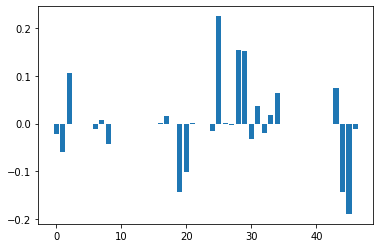

In [30]:
from matplotlib import pyplot
pyplot.bar([x for x in range(len(importance))], importance)